Initialise  
Mid price - classification rather than, 
Label - neural network (Random Forest)
mid-price

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import glob
import re
from datetime import datetime

Import data

In [9]:
# Path pattern to match all CSV files
path_pattern = r'C:\Users\Tim\Documents\Bristol Uni\dsmp-2024-group18\ARIMA Model Development\Month Prediction\Month Data\January\*.csv'
all_files = glob.glob(path_pattern)

# List to hold all dataframes
li = []

for filename in all_files:
    # Extract date from filename using regex
    date_match = re.search(r'(\d{4}-\d{2}-\d{2})', filename)
    if date_match:
        file_date = datetime.strptime(date_match.group(), '%Y-%m-%d').date()
    
    df = pd.read_csv(filename, index_col=None, header=0)
    
    # Combine the extracted date with each 'Time' entry, assuming 'Time' is just time
    df['Time'] = pd.to_datetime(df['Time'].astype(str)).apply(lambda x: datetime.combine(file_date, x.time()))
    
    li.append(df)

# Concatenate all data into a single DataFrame
data = pd.concat(li, axis=0, ignore_index=True)

# Ensure 'Time' includes full datetime information and set it as the index
data.set_index('Time', inplace=True)

# Select only the numeric columns for resampling
numeric_data = data.select_dtypes(include=[np.number])

# Resample the numeric data to every minute, calculating the mean
data = numeric_data.resample('1T').mean()

data = data.dropna(subset=['Mid-Price'])

print(data.head())


C:\Users\Tim\AppData\Local\Temp\ipykernel_5436\535320902.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'].astype(str)).apply(lambda x: datetime.combine(file_date, x.time()))
C:\Users\Tim\AppData\Local\Temp\ipykernel_5436\535320902.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'].astype(str)).apply(lambda x: datetime.combine(file_date, x.time()))
C:\Users\Tim\AppData\Local\Temp\ipykernel_5436\535320902.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time

                      Mid-Price  Total_volume  Bid_ask_spread  Order_imbalance
Time                                                                          
2025-01-02 07:30:00  263.588667    178.266667       20.544833         0.057500
2025-01-02 07:31:00  260.393500    157.416667        4.887333         0.122167
2025-01-02 07:32:00  265.426667    160.966667        4.646667         0.162667
2025-01-02 07:33:00  265.109333    150.300000        4.184167         0.041167
2025-01-02 07:34:00  265.925167    202.983333        5.501167         0.143500


C:\Users\Tim\AppData\Local\Temp\ipykernel_5436\535320902.py:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data = numeric_data.resample('1T').mean()


Get a df with just time and mid-price

In [10]:
mid_price_df = pd.DataFrame()
mid_price_df['Mid-Price'] = data['Mid-Price']
mid_price_df.set_index(data.index, inplace=True)
mid_price_df.reset_index(drop=True, inplace=True)

print(type(mid_price_df))
print(mid_price_df.to_string(index=True, header=True))


<class 'pandas.core.frame.DataFrame'>
        Mid-Price
0      263.588667
1      260.393500
2      265.426667
3      265.109333
4      265.925167
5      263.155667
6      261.527500
7      262.878333
8      264.026667
9      264.865000
10     268.018500
11     266.129333
12     264.372333
13     258.297833
14     256.795833
15     276.059667
16     270.809333
17     300.179500
18     269.993667
19     276.044500
20     271.211500
21     265.762667
22     255.792833
23     300.344500
24     273.449833
25     256.248000
26     267.661000
27     254.277000
28     251.661500
29     269.238000
30     256.930667
31     266.142000
32     267.202833
33     261.974500
34     250.584500
35     286.109500
36     272.026500
37     304.678667
38     306.375833
39     286.087167
40     281.245000
41     270.044500
42     268.963667
43     264.013000
44     264.210667
45     257.862500
46     271.382167
47     260.938833
48     261.295500
49     256.989667
50     257.341833
51     261.216833
52     2

Split the data 80:20 by time

        Mid-Price
11215  323.031000
11216  328.927833
11217  321.353500
11218  329.632500
11219  326.133667


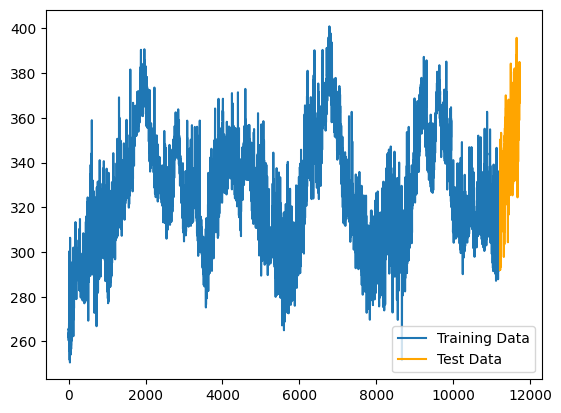

In [11]:
# Get just the mid price
day_length = 510 # 510 points per day

split_index = int(len(data) - day_length)


# Split the DataFrame into train and test sets based on the split index
train = (mid_price_df[0:split_index])
test = (mid_price_df[split_index:])

print(train.tail())

plt.plot(train, label = 'Training Data')
plt.plot(test, color = 'orange', label = 'Test Data')
plt.legend()
plt.show()


Do ADF Test to check if data is stationary 

In [12]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(mid_price):
    result=adfuller(mid_price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [13]:
adfuller_test(train['Mid-Price'])

ADF Test Statistic : -3.396546318649843
p-value : 0.011077172322188265
#Lags Used : 24
Number of Observations Used : 11195
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Plot ACF

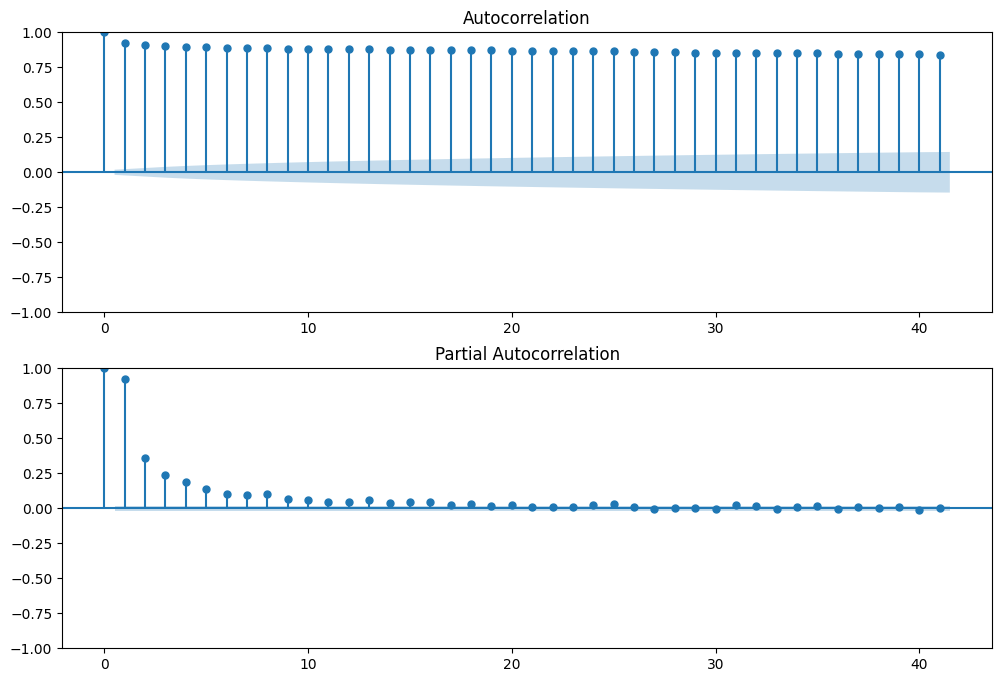

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train, ax=ax[0])  # ACF plot for 'Mid-Price'
plot_pacf(train, ax=ax[1])  # PACF plot for 'Mid-Price'

plt.show()

Use pdarima package to check d calc

In [15]:
from pmdarima.arima.utils import ndiffs 
ndiffs(train, test = "adf")

0

Plot interpretation

ACF Plot Interpretation:

The ACF plot tails off gradually, which indicates that the data may be either an AR process or a mixed ARMA process. In an ACF plot for a pure MA process, we would expect a sharp cut-off after the significant lags. Therefore p = 1.

PACF Plot Interpretation:

The PACF plot shows a significant spike at lag 1, and then it almost immediately cuts off (becomes insignificant). Given the lack of significant spikes in the ACF plot beyond the immediate lag, I will start with q=0 and test q=1 as well.

Differencing Term (d):

As per the ADF test, the data is stationary so d = 0




Do ARIMA Test

In [28]:
print(train)

0        263.588667
1        260.393500
2        265.426667
3        265.109333
4        265.925167
            ...    
11215    323.031000
11216    328.927833
11217    321.353500
11218    329.632500
11219    326.133667
Name: Mid-Price, Length: 11220, dtype: float64


In [26]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

print(train)
# Use auto_arima to find the best ARIMA parameters
auto_model = auto_arima(train, seasonal=False, trace=True)
# Print the summary of the best model
print(auto_model.summary())
# Extract the best order
best_order = auto_model.order
print("Best ARIMA order:", best_order)

# Now you can use the best order to fit your ARIMA model
model = ARIMA(train, order=best_order)
model_fit = model.fit()


0        263.588667
1        260.393500
2        265.426667
3        265.109333
4        265.925167
            ...    
11215    323.031000
11216    328.927833
11217    321.353500
11218    329.632500
11219    326.133667
Name: Mid-Price, Length: 11220, dtype: float64
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=78976.582, Time=9.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82924.565, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=81127.360, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=79411.255, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82922.569, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=78978.617, Time=3.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=78981.325, Time=2.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=78985.301, Time=3.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=78982.617, Time=4.81 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=78994.377, Time=1.99 sec
 ARIMA(1,1,3)(0,0,0)

In [29]:
horizon = 1  # Predicting one step ahead

predictions = []
actuals = []

# Start the rolling forecasting
for end in range(split_index, len(mid_price_df) - horizon + 1):
    
    # Extract current training data
    train = mid_price_df['Mid-Price'].iloc[:end]
    
    # Fit the ARIMA model with the chosen order
    model = ARIMA(train, order=best_order)  # Ensure you've chosen the best order
    model_fit = model.fit()
    
    # Forecast the next point
    forecast = model_fit.forecast(steps=horizon)
    predictions.append(forecast.iloc[0])  # Appending the forecasted value
    
    # Appending the actual value for comparison
    actuals.append(mid_price_df['Mid-Price'].iloc[end + horizon - 1])


In [30]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(actuals, predictions)
print('Test Mean Squared Error:', error)

print(predictions)
print(actuals)

Test Mean Squared Error: 138.43520980987222
[321.1500294473928, 309.13796191629206, 310.2239697466457, 307.80299626462886, 305.17354073507397, 302.80141970295733, 301.40271462923874, 321.7062221425285, 320.2240132108579, 317.5285702104372, 322.73708007090266, 324.36527623958006, 310.3303045259036, 326.04141218081486, 316.8596316606671, 315.51377024958646, 325.6102483976373, 324.1044598094164, 322.1719379633347, 327.14451745608045, 331.08742031741536, 321.17453795409284, 320.9039866915643, 319.5008727873826, 319.0603407985248, 318.38705492673137, 318.2370481223019, 313.3203476790227, 318.2564405257574, 324.27728609465146, 327.07807893267307, 334.353281477502, 326.7158394550599, 329.1754919667106, 329.502424028165, 329.85223172041333, 331.19040955345014, 329.1332036688681, 334.7529373021884, 328.3955303951486, 328.50439250422454, 334.4918744228216, 323.29988222079, 328.2709396708374, 333.8174203063724, 324.84531630905883, 326.4335559408425, 330.61878709264585, 326.5369945947104, 330.3095

Plot

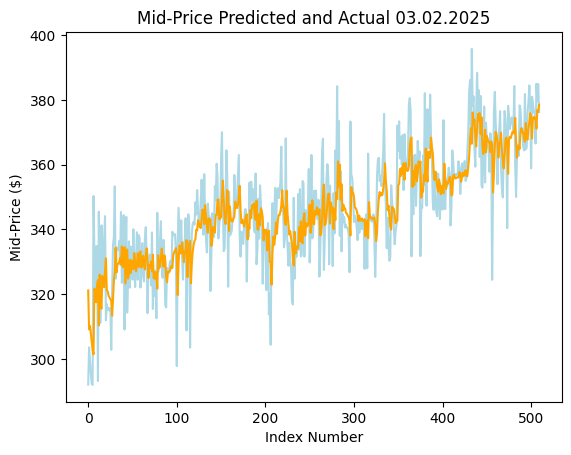

In [34]:
plt.plot(actuals, color = 'lightblue', label = 'Actual')
plt.plot(predictions, color = 'orange', label = 'Predicted')
plt.title('Mid-Price Predicted and Actual 03.02.2025')
plt.xlabel('Index Number')
plt.ylabel('Mid-Price ($)')
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(actuals, predictions)
print('Test Mean Squared Error:', error)

print(predictions)
print(actuals)

Test Mean Squared Error: 138.43520980987222
[321.1500294473928, 309.13796191629206, 310.2239697466457, 307.80299626462886, 305.17354073507397, 302.80141970295733, 301.40271462923874, 321.7062221425285, 320.2240132108579, 317.5285702104372, 322.73708007090266, 324.36527623958006, 310.3303045259036, 326.04141218081486, 316.8596316606671, 315.51377024958646, 325.6102483976373, 324.1044598094164, 322.1719379633347, 327.14451745608045, 331.08742031741536, 321.17453795409284, 320.9039866915643, 319.5008727873826, 319.0603407985248, 318.38705492673137, 318.2370481223019, 313.3203476790227, 318.2564405257574, 324.27728609465146, 327.07807893267307, 334.353281477502, 326.7158394550599, 329.1754919667106, 329.502424028165, 329.85223172041333, 331.19040955345014, 329.1332036688681, 334.7529373021884, 328.3955303951486, 328.50439250422454, 334.4918744228216, 323.29988222079, 328.2709396708374, 333.8174203063724, 324.84531630905883, 326.4335559408425, 330.61878709264585, 326.5369945947104, 330.3095

In [36]:
# Generate a datetime index with any base date
time_index = pd.date_range(start="2025-02-03 07:30:00", periods=510, freq='T')

# Extract just the time component, though note these are still datetime objects, just formatted to show only time
time_only_series = time_index.time

In [38]:
mid_price_pred = pd.DataFrame()
mid_price_pred['Actual'] = actuals
mid_price_pred['Predicted'] = predictions
mid_price_pred['Time'] = time_only_series

mid_price_pred.to_csv('Predicted Mid-Price (Month).csv')